In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import os
from glob import glob
import wandb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision import transforms
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2
#test 


In [40]:

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wi21177 (wi21177_dhbw). Use `wandb login --relogin` to force relogin


True

In [41]:
class CustomDataset(Dataset):
    def __init__(self, root, data, transformations=None, im_files=[".jpg", ".jpeg", ".png"]):
        # Initialisiert die Attribute und sammelt alle Bildpfade
        self.transformations, self.data = transformations, data
        self.im_paths = []
        
        # Durchsucht das Verzeichnis nach Bilddateien mit den angegebenen Erweiterungen
        for im_file in im_files:
            self.im_paths.extend(sorted(glob(os.path.join(root, data, '*', '*' + im_file))))
        
        # Initialisiert die Klassenbezeichnungen und -anzahlen
        self.cls_names, self.cls_counts, count = {}, {}, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = os.path.basename(os.path.dirname(im_path))
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

        # Gibt die Anzahl der Bilder im Dataset aus
        print(f'{data} dataset - Number of images: {len(self.im_paths)}')

    def __len__(self):
        # Gibt die Gesamtzahl der Bilder im Dataset zurück
        return len(self.im_paths)

    def __getitem__(self, idx):
        # Lädt das Bild und die zugehörige Klasse für den angegebenen Index
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[os.path.basename(os.path.dirname(im_path))]

        # Wendet optionale Transformationen auf das Bild an
        if self.transformations is not None:
            im = self.transformations(im)

        # Gibt das Bild und die Klasse zurück
        return im, gt


In [42]:
def get_dls(root, transformations, bs, ns=0):  # Set num_workers to 0 for debugging
    # Erstellt die Trainings-, Validierungs- und Test-Datasets
    tr_ds = CustomDataset(root=root, data="train", transformations=transformations)
    vl_ds = CustomDataset(root=root, data="validation", transformations=transformations)
    ts_ds = CustomDataset(root=root, data="test", transformations=transformations)
    
    # Erstellt die DataLoader für das Trainings-Dataset
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    
    # Erstellt die DataLoader für das Validierungs-Dataset
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    
    # Erstellt die DataLoader für das Test-Dataset
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    
    # Gibt die DataLoader und die Klassenbezeichnungen zurück
    return tr_dl, val_dl, ts_dl, tr_ds.cls_names


In [43]:
root = "data"  # Verzeichnis, in dem die Daten gespeichert sind
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224  # Normalisierungsparameter und Bildgröße

# Definiert die Bildtransformationen: Größe ändern, in Tensor konvertieren und normalisieren
tfs = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Erstellt die DataLoader für Trainings-, Validierungs- und Test-Datasets
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

# Druckt die Länge der DataLoader (Anzahl der Batches) und die Klassenbezeichnungen
print(f'Training DataLoader Length: {len(tr_dl)}')
print(f'Validation DataLoader Length: {len(val_dl)}')
print(f'Test DataLoader Length: {len(ts_dl)}')
print(f'Classes: {classes}')


train dataset - Number of images: 1361
validation dataset - Number of images: 500
test dataset - Number of images: 60
Training DataLoader Length: 43
Validation DataLoader Length: 16
Test DataLoader Length: 60
Classes: {'classic': 0, 'manga': 1}


In [44]:
def test_data_loading(dl):
    data_iter = iter(dl)
    for i in range(5):  # Load 5 batches to check for issues
        try:
            images, labels = next(data_iter)
            print(f'Batch {i+1}: Loaded {images.size(0)} images.')
        except StopIteration:
            print(f'Batch {i+1}: No more data.')
            break

# Test loading training data
print("Training DataLoader:")
test_data_loading(tr_dl)
# Test loading validation data
print("Validation DataLoader:")
test_data_loading(val_dl)
# Test loading test data
print("Test DataLoader:")
test_data_loading(ts_dl)


Training DataLoader:
Batch 1: Loaded 32 images.
Batch 2: Loaded 32 images.
Batch 3: Loaded 32 images.
Batch 4: Loaded 32 images.
Batch 5: Loaded 32 images.
Validation DataLoader:
Batch 1: Loaded 32 images.
Batch 2: Loaded 32 images.
Batch 3: Loaded 32 images.
Batch 4: Loaded 32 images.
Batch 5: Loaded 32 images.
Test DataLoader:
Batch 1: Loaded 1 images.
Batch 2: Loaded 1 images.
Batch 3: Loaded 1 images.
Batch 4: Loaded 1 images.
Batch 5: Loaded 1 images.


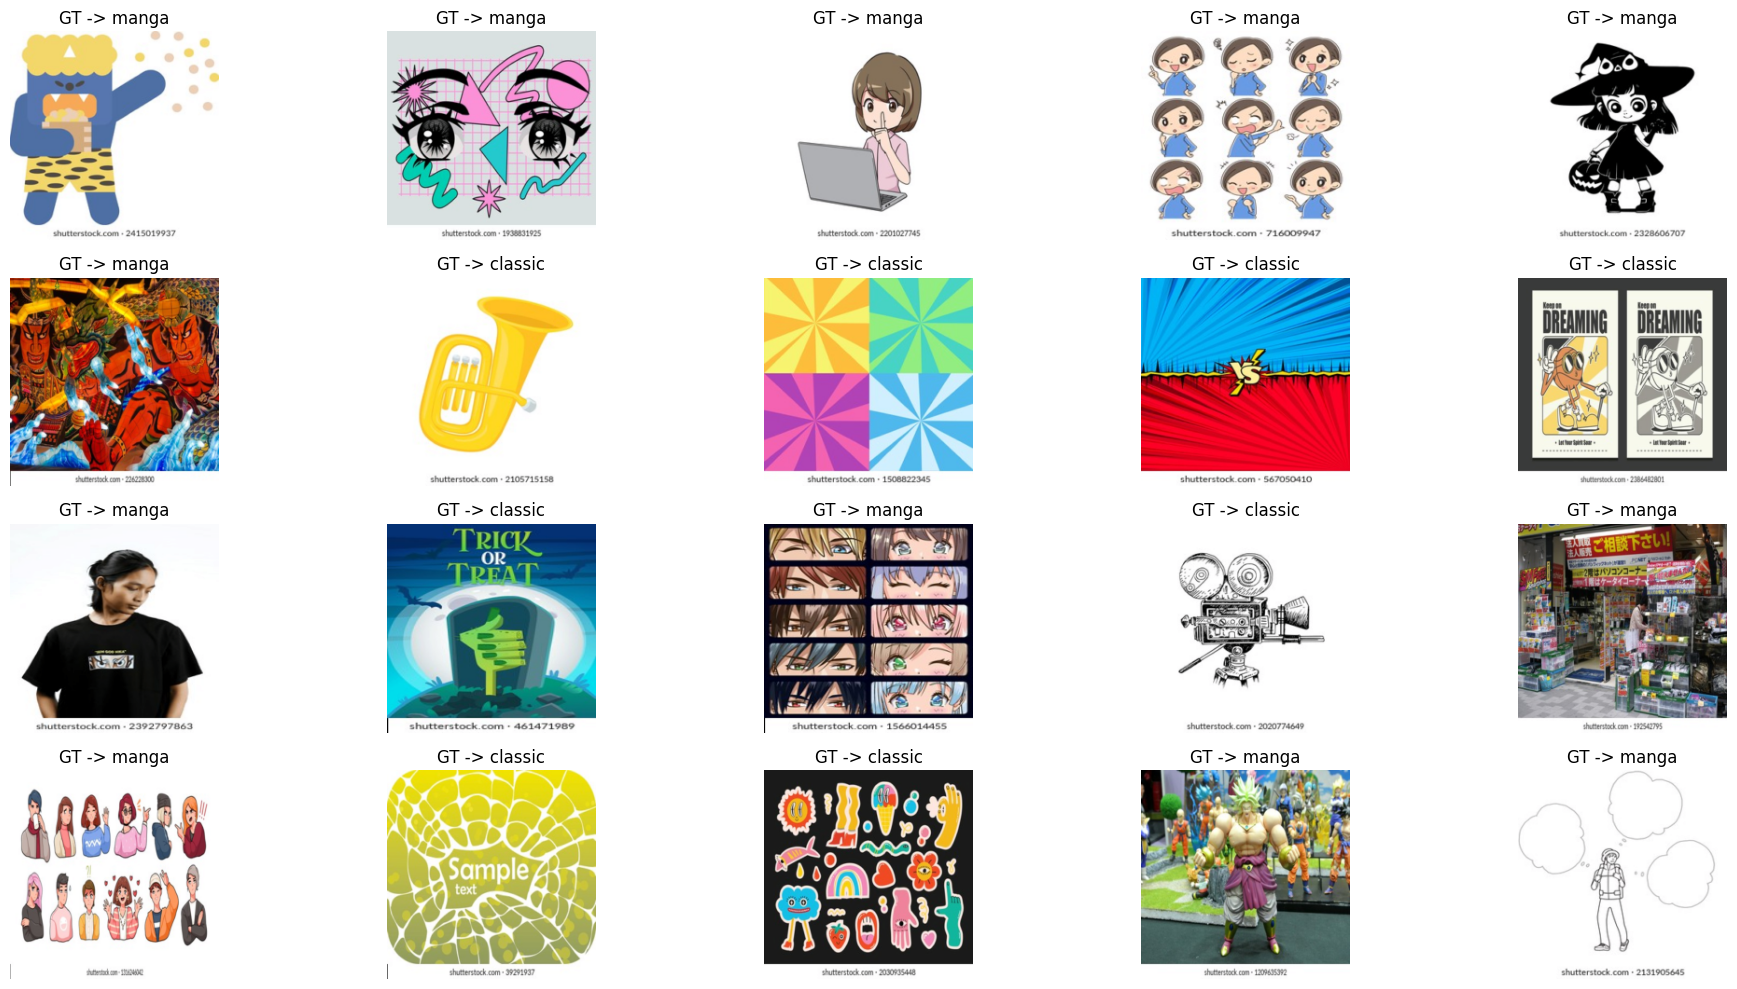

In [45]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T

def convert_tensor_to_image(tensor, t_type="rgb"):
    """
    Konvertiert einen Tensor in ein Numpy-Array-Bild mit umgekehrter Normalisierung.
    """
    if t_type == "gray":
        transform = T.Compose([
            T.Normalize(mean=[0.0], std=[1/0.5]),
            T.Normalize(mean=[-0.5], std=[1])
        ])
    else:
        transform = T.Compose([
            T.Normalize(mean=[0.0, 0.0, 0.0], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0])
        ])
    
    # Transformiert den Tensor und konvertiert ihn in ein Numpy-Array-Bild
    image = (transform(tensor) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    return image

def display_images(dataset, n_images, nrows, cmap_type=None, class_names=None):
    """
    Zeigt eine Reihe von Bildern aus dem Dataset an.
    """
    assert cmap_type in ["rgb", "gray"], "Geben Sie an, ob die Bilder grau oder RGB sind!"
    
    if cmap_type == "rgb":
        cmap_type = "viridis"
    
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(dataset)), n_images)
    ncols = n_images // nrows

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(nrows, ncols, i + 1)
        if cmap_type:
            plt.imshow(convert_tensor_to_image(img, t_type=cmap_type), cmap=cmap_type)
        else:
            plt.imshow(convert_tensor_to_image(img))
        plt.axis('off')
        if class_names is not None:
            plt.title(f"GT -> {class_names[int(label)]}")
        else:
            plt.title(f"GT -> {label}")
    
    plt.tight_layout()
    plt.show()

# Beispielhafte Verwendung mit dem Training DataLoader
display_images(tr_dl.dataset, 20, 4, cmap_type="rgb", class_names=list(classes.keys()))


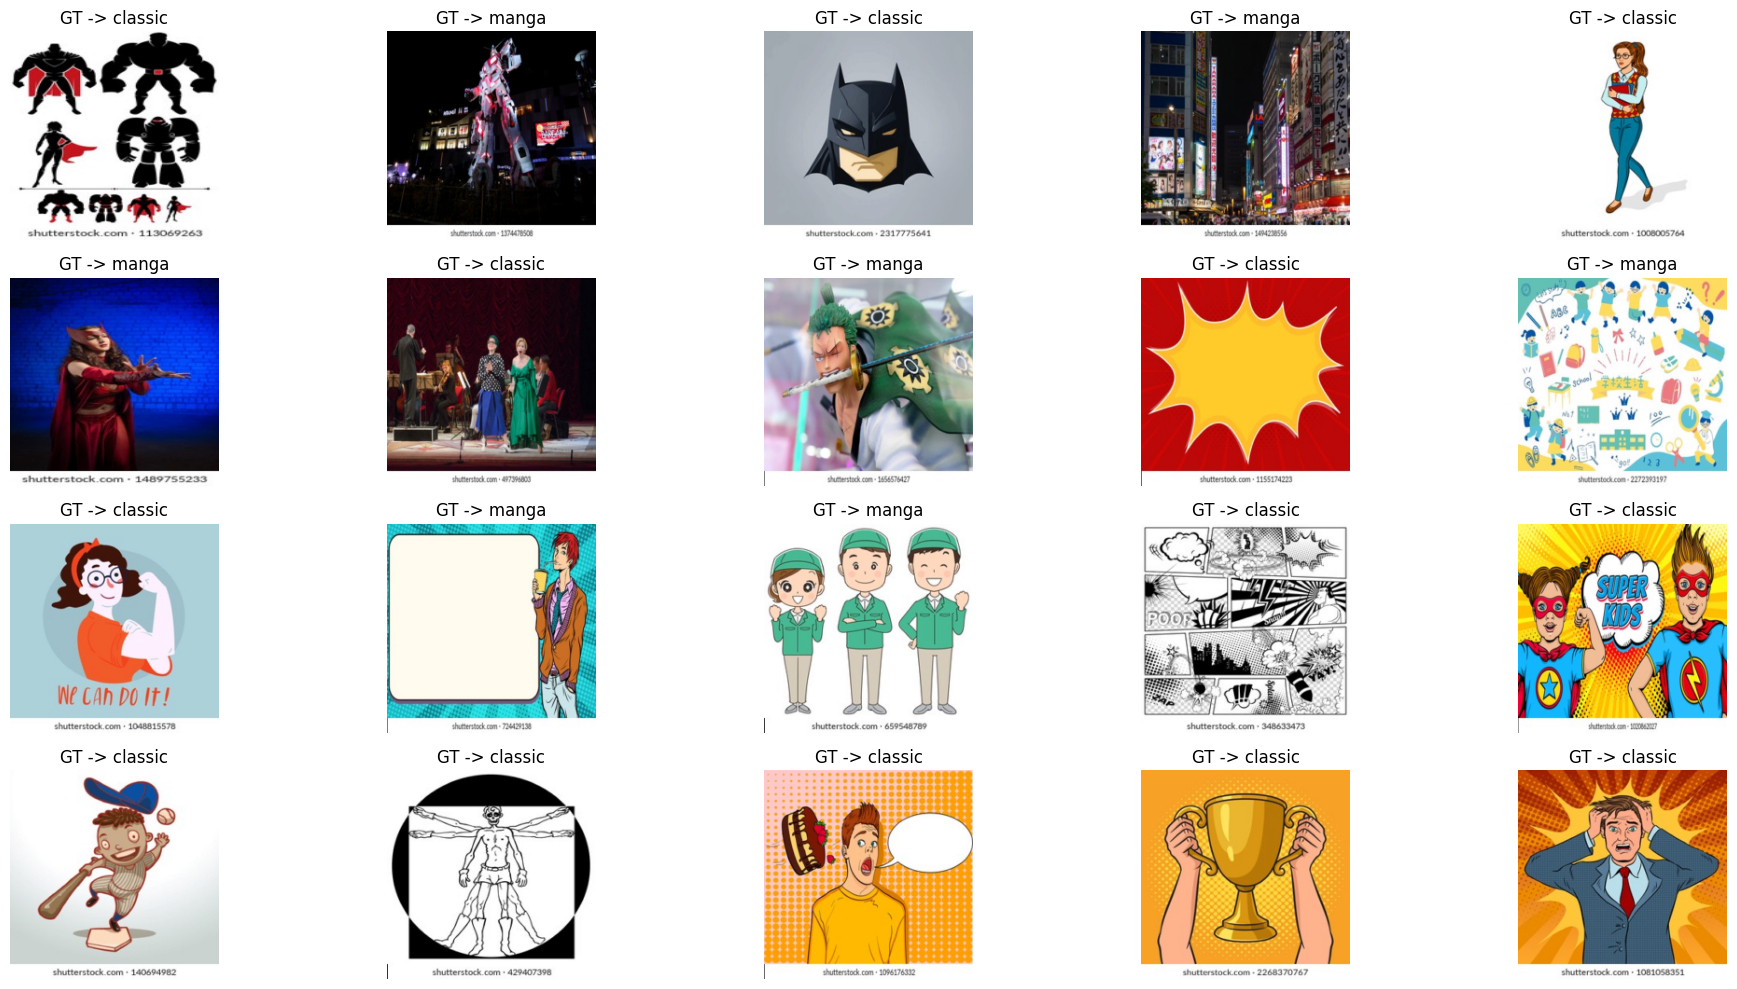

In [46]:
display_images(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

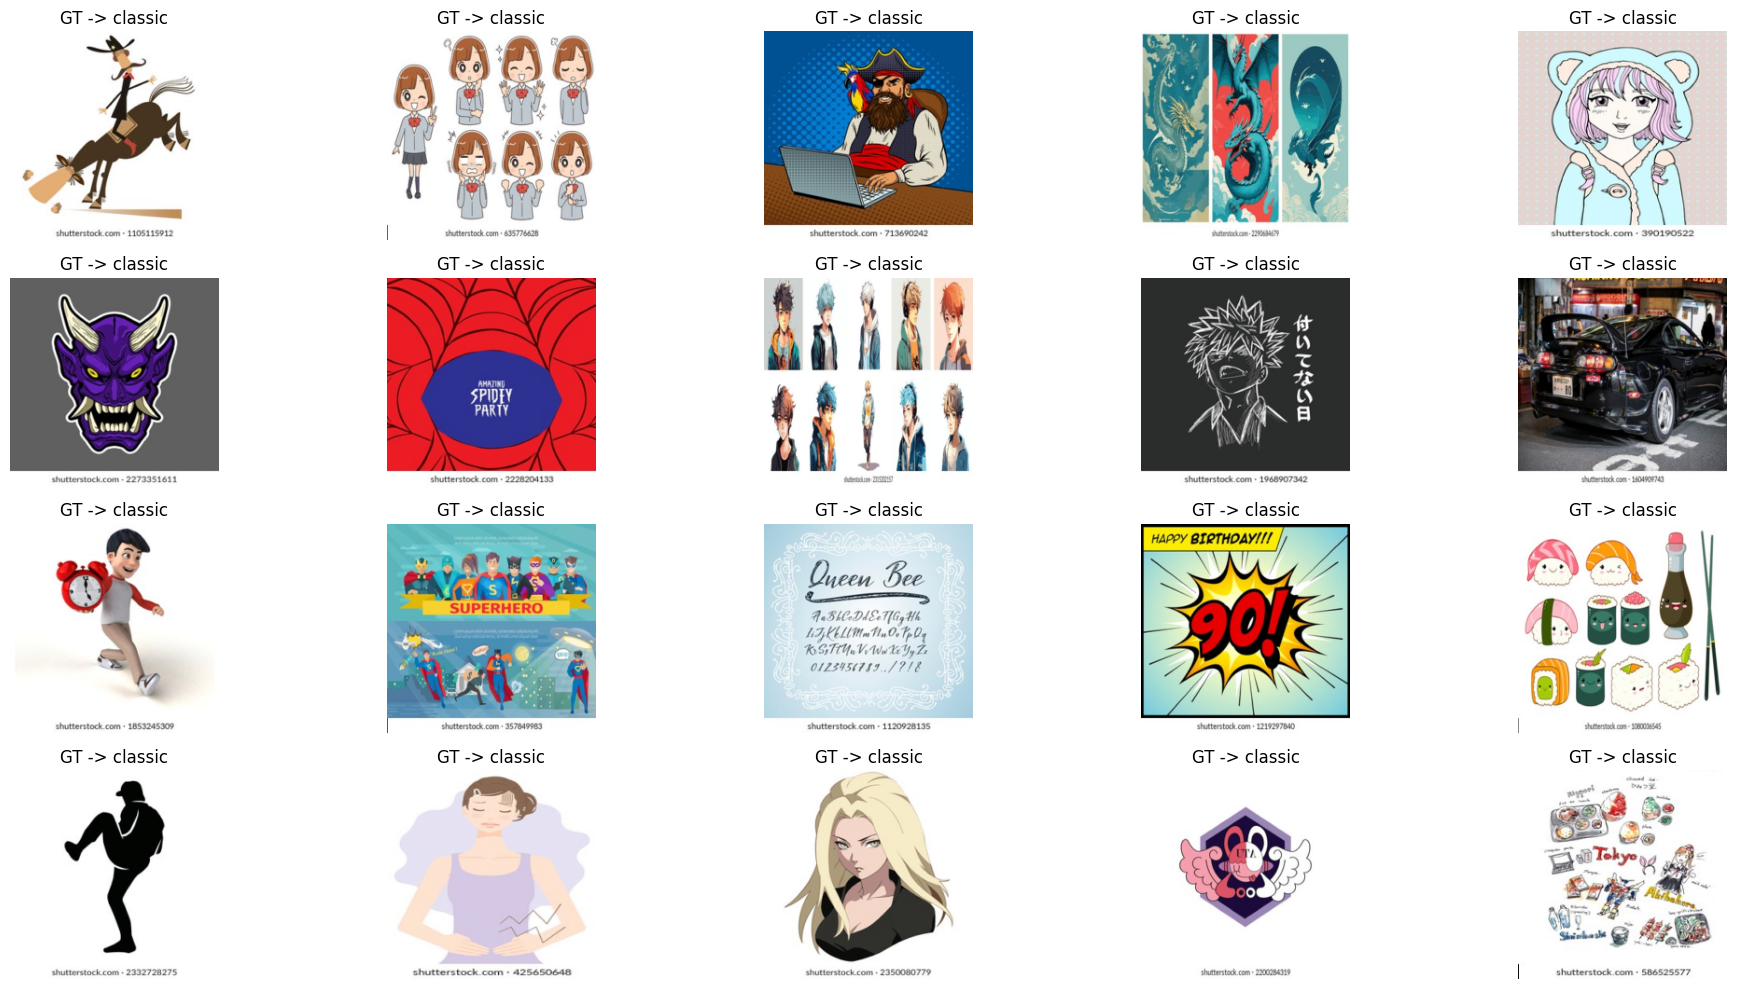

In [68]:
display_images(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [48]:

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define your model with Dropout
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

Using device: cpu


In [49]:

# Instantiate the model
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')  # Save the best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, delta=0.01)

In [50]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """
    Trainiert das Modell für eine Epoche.
    
    Parameter:
    model - Das zu trainierende Modell
    dataloader - DataLoader für das Training
    optimizer - Optimizer für das Modell
    criterion - Verlustfunktion
    device - Gerät (CPU oder GPU), auf dem das Training durchgeführt wird

    Rückgabe:
    average_loss - Durchschnittlicher Verlust über die Epoche
    accuracy - Genauigkeit des Modells über die Epoche
    """
    model.train()
    total_loss, total_correct, total_images = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)
    
    accuracy = 100.0 * total_correct / total_images
    average_loss = total_loss / len(dataloader)
    return average_loss, accuracy

def validate(model, dataloader, criterion, device):
    """
    Validiert das Modell.
    
    Parameter:
    model - Das zu validierende Modell
    dataloader - DataLoader für die Validierung
    criterion - Verlustfunktion
    device - Gerät (CPU oder GPU), auf dem die Validierung durchgeführt wird

    Rückgabe:
    average_loss - Durchschnittlicher Verlust über die Validierung
    accuracy - Genauigkeit des Modells über die Validierung
    """
    model.eval()
    total_loss, total_correct, total_images = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
    
    accuracy = 100.0 * total_correct / total_images
    average_loss = total_loss / len(dataloader)
    return average_loss, accuracy


In [51]:
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values':[1e-5, 1e-4,1e-3]},
        'batch_size': {'values': [16, 32, 64]}
    }
}

def sweep_run():
    with wandb.init() as run:
        config = wandb.config
        model = SimpleCNN(dropout_rate=0.2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss()
        transformations = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        tr_dl, val_dl, _, _ = get_dls(root='data', transformations=transformations, bs=config.batch_size)
        for epoch in range(10):
            train_loss, train_accuracy = train_one_epoch(model, tr_dl, optimizer, criterion, device)
            val_loss, val_accuracy = validate(model, val_dl, criterion, device)
            wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy,
                       'val_loss': val_loss, 'val_accuracy': val_accuracy})
        wandb.save('model.pth')

# Initialisieren des Sweeps
sweep_id = wandb.sweep(sweep_config, project='comic-vs-manga-classification')
wandb.agent(sweep_id, sweep_run, count=1)



Create sweep with ID: 82cujr4w
Sweep URL: https://wandb.ai/wi21177_dhbw/comic-vs-manga-classification/sweeps/82cujr4w


wandb: Agent Starting Run: 9al52xwr with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train dataset - Number of images: 1361
validation dataset - Number of images: 500
test dataset - Number of images: 60


In [82]:
def evaluate_model(model, val_dl):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Unpack the output if model returns a tuple
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # assuming the first element is the output tensor
            _, predicted = torch.max(outputs, 1)  # Remove .data as it is deprecated
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Load the model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Evaluate the model
evaluate_model(model, val_dl)  # Assuming ts_dl is your test DataLoader


Test Accuracy: 71.60%


Test Accuracy: 71.60%


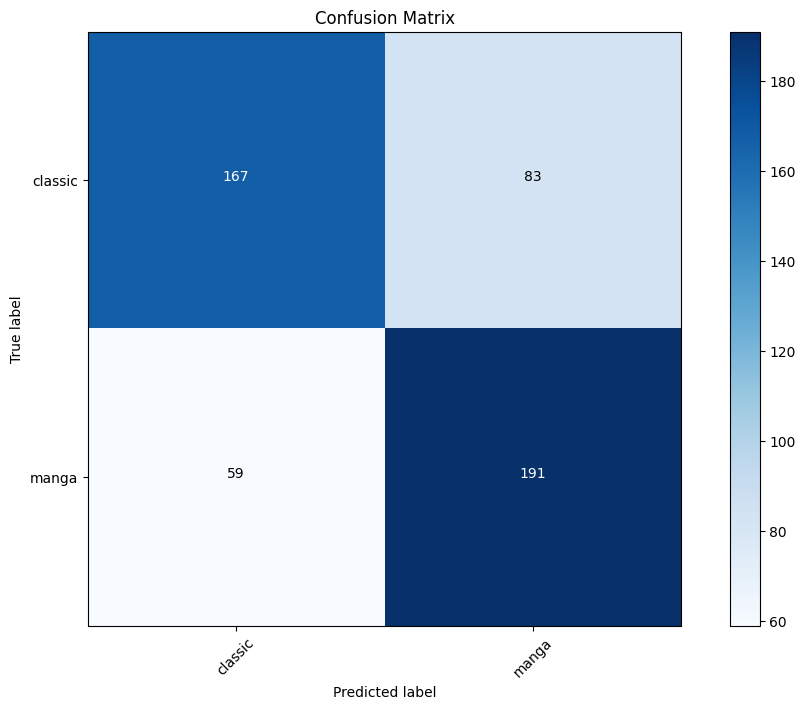

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [85]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model and compute the confusion matrix
def evaluate_model_and_confusion_matrix(model, val_dl, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Unpack the outputs if the model returns a tuple
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Assuming the first element is the desired output
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = 100 * (np.array(y_pred) == np.array(y_true)).sum() / len(y_true)
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Plotting the confusion matrix using matplotlib
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return y_true, y_pred, cm

# Call the function to evaluate the model and display the confusion matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model_and_confusion_matrix(model, val_dl, device, list(classes.keys()))


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Funktion zum Sammeln von Labels aus dem DataLoader (angenommen, du hast bereits einen DataLoader 'test_loader')
def get_labels(loader):
    labels_list = []
    for _, labels in loader:
        labels_list.extend(labels.numpy())
    return labels_list

true_labels = get_labels(val_dl)  # Dein DataLoader für den Testdatensatz

# Initialisiere den Dummy-Classifier mit einer gleichförmigen Verteilungsstrategie
dummy_clf = DummyClassifier(strategy="uniform")

# Trainiere den Dummy-Classifier (die Eingaben sind hier nicht relevant, nur die Labels)
dummy_clf.fit(np.zeros_like(true_labels), true_labels)

# Generiere Vorhersagen
dummy_predictions = dummy_clf.predict(np.zeros_like(true_labels))
# Berechne die Konfusionsmatrix
dummy_conf_matrix = confusion_matrix(true_labels, dummy_predictions)

# Klassifikationsbericht
dummy_report = classification_report(true_labels, dummy_predictions, target_names=['Manga', 'Comic'])  # Namen der Klassen anpassen

print("Konfusionsmatrix des Dummy-Classifiers:")
print(dummy_conf_matrix)
print("\nKlassifikationsbericht des Dummy-Classifiers:")
print(dummy_report)



60it [00:01, 45.89it/s]


Model accuracy on test data: 0.450


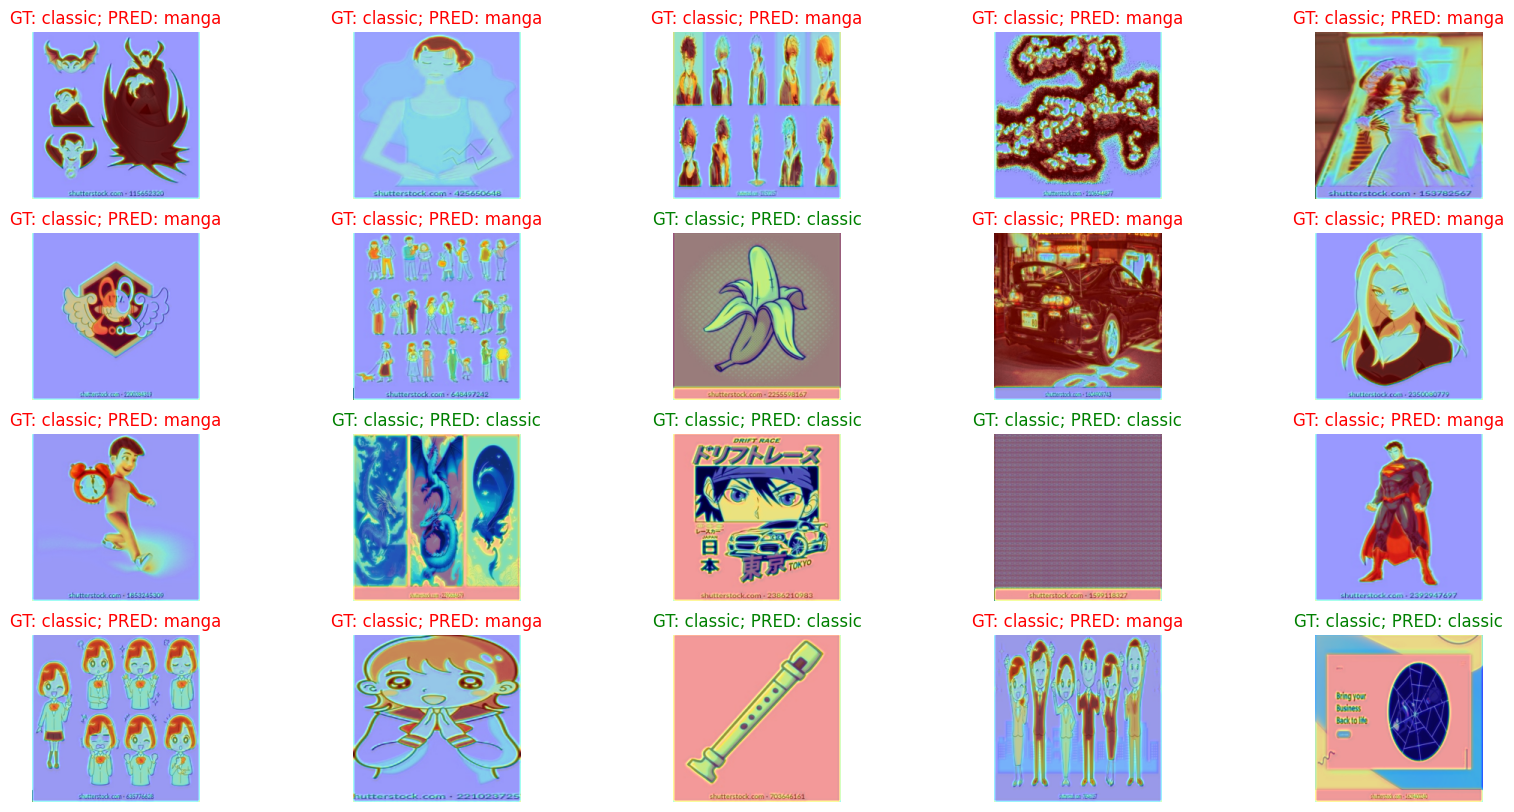

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm
from torchvision.transforms import ToPILImage

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        features = x  # Save the features for CAM computation
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x, features

class FeatureExtractor:
    """ Extract activations from the pretrained model """
    def __init__(self, model_layer):
        self.features = None
        self.hook = model_layer.register_forward_hook(self.save_features)

    def save_features(self, module, input, output):
        self.features = output.cpu().data.numpy()

    def remove(self):
        self.hook.remove()

def compute_cam(features, weights, class_idx):
    """
    Compute the class activation map (CAM) for the given class index.
    
    Args:
    - features: The feature maps from the convolutional layer.
    - weights: The weights from the fully connected layer.
    - class_idx: The index of the target class.
    
    Returns:
    - cam: The class activation map.
    """
    # features shape: (batch_size, num_channels, height, width)
    # weights shape: (num_classes, num_fc_features)
    
    # Reshape features to (num_channels, height * width)
    batch_size, num_channels, height, width = features.shape
    features_reshaped = features[0].reshape((num_channels, height * width))
    
    # Reduce the weights to match the number of channels in the final conv layer
    cam = weights[class_idx][:num_channels].dot(features_reshaped)
    
    # Reshape the result back to the spatial dimensions
    cam = cam.reshape(height, width)
    
    # Normalize the CAM
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    return cam

def tensor_to_image(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    np_image = tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    np_image = np.clip(np_image, 0, 1)
    return np_image

def run_inference_with_gradcam(model, device, test_loader, num_images, rows, final_conv_layer, fc_weights, class_names=None):
    weights = np.squeeze(fc_weights[0].cpu().data.numpy())
    feature_extractor = FeatureExtractor(final_conv_layer)
    predictions, imgs, labels = [], [], []

    for idx, (images, gts) in tqdm(enumerate(test_loader)):
        images, gts = images.to(device), gts.to(device)
        outputs, _ = model(images)
        preds = torch.argmax(outputs, dim=1)
        imgs.extend(images.cpu())
        predictions.extend(preds.cpu().numpy())
        labels.extend(gts.cpu().numpy())

    accuracy = (np.array(predictions) == np.array(labels)).sum() / len(labels)
    print(f"Model accuracy on test data: {accuracy:.3f}")

    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(imgs)), num_images)

    for i, idx in enumerate(indices):
        img = imgs[idx].unsqueeze(0).to(device)
        pred_idx = predictions[idx]
        # Extract features for the current image
        _ = model(img)
        features = feature_extractor.features
        heatmap = compute_cam(features, weights, pred_idx)

        plt.subplot(rows, num_images // rows, i + 1)
        img = img.squeeze().cpu()
        plt.imshow(tensor_to_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        plt.imshow(cv2.resize(heatmap, (img.shape[1], img.shape[2])), alpha=0.4, cmap='jet')
        plt.axis('off')
        if class_names is not None:
            gt_label = class_names[int(labels[idx])]
            pred_label = class_names[int(predictions[idx])]
            plt.title(f"GT: {gt_label}; PRED: {pred_label}", color=("green" if gt_label == pred_label else "red"))
        else:
            plt.title(f"GT: {labels[idx]}; PRED: {predictions[idx]}")

    plt.show()

# Load the model
model = SimpleCNN()  # Replace SimpleCNN with your actual model class if different
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# Hook to the final conv layer
final_conv_layer = model.conv2  # Assuming conv2 is the final conv layer, adjust accordingly
fc_weights = list(model.fc2.parameters())

# Run inference with GradCAM
run_inference_with_gradcam(model=model, device=device, test_loader=ts_dl, num_images=20, rows=4, final_conv_layer=final_conv_layer, fc_weights=fc_weights, class_names=list(classes.keys()))


100%|██████████| 60/60 [00:00<00:00, 62.70it/s]


Model accuracy on test data: 0.850


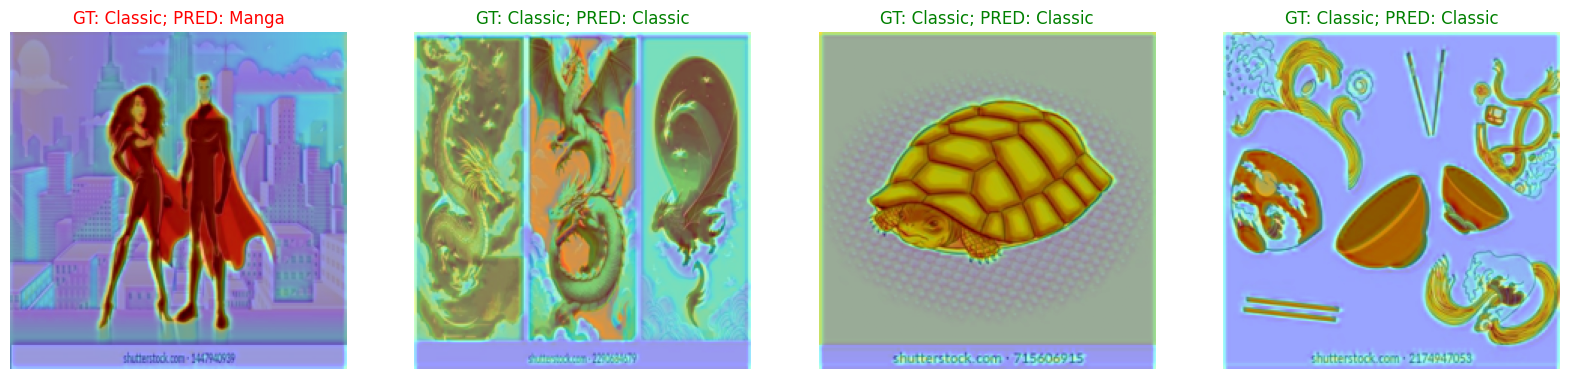

In [91]:


# Assuming the definition of SimpleCNN and the required imports are already present in earlier cells.

class FeatureExtractor:
    """ Extract activations from the model during forward pass. """
    def __init__(self, model_layer):
        self.features = None
        self.hook = model_layer.register_forward_hook(self.save_features)

    def save_features(self, module, input, output):
        self.features = output  # Keeps the tensor format

    def remove(self):
        self.hook.remove()

def compute_cam(features, weights, class_idx):
    """
    Compute the class activation map (CAM) for the given class index using PyTorch tensors.

    Args:
    - features: The feature maps from the convolutional layer (PyTorch Tensor).
    - weights: The weights from the fully connected layer (PyTorch Tensor).
    - class_idx: The index of the target class.

    Returns:
    - cam: The class activation map (PyTorch Tensor).
    """
    # Ensure features are not empty and have required gradients
    if features.requires_grad:
        features.retain_grad()

    # Reshape features to (num_channels, height * width)
    features_reshaped = features[0].reshape(features.size(1), -1)

    # Extract the correct weights and perform the dot product
    class_weights = weights[class_idx, :features.size(1)]
    cam = torch.matmul(class_weights, features_reshaped)

    # Reshape the result back to the spatial dimensions
    cam = cam.reshape(features.size(2), features.size(3))

    # Normalize the CAM for better visualization
    cam = (cam - torch.min(cam)) / (torch.max(cam) - torch.min(cam))
    return cam

def tensor_to_image(tensor, mean, std):
    """
    Convert a tensor to a numpy image format for visualization.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    np_image = tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    np_image = np.clip(np_image, 0, 1)
    return np_image

def run_inference_with_gradcam(model, device, test_loader, num_images, rows, final_conv_layer, fc_weights, class_names=None):
    """
    Perform inference using the model and visualize with GradCAM.
    """
    feature_extractor = FeatureExtractor(final_conv_layer)
    predictions, imgs, labels = [], [], []

    # Iterate through the test data
    for images, gts in tqdm(test_loader):
        images, gts = images.to(device), gts.to(device)
        outputs, features = model(images)
        preds = torch.argmax(outputs, dim=1)
        imgs.extend(images.cpu())
        predictions.extend(preds.cpu().numpy())
        labels.extend(gts.cpu().numpy())

    accuracy = (np.array(predictions) == np.array(labels)).sum() / len(labels)
    print(f"Model accuracy on test data: {accuracy:.3f}")

    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(imgs)), num_images)

    # Generate GradCAM for selected images
    for i, idx in enumerate(indices):
        img = imgs[idx].unsqueeze(0).to(device)
        pred_idx = predictions[idx]
        _ = model(img)
        features = feature_extractor.features
        heatmap = compute_cam(features, fc_weights, pred_idx)
        img = tensor_to_image(img.squeeze(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        plt.subplot(rows, num_images // rows, i + 1)
        plt.imshow(img)
        plt.imshow(cv2.resize(heatmap.cpu().detach().numpy(), img.shape[0:2]), alpha=0.4, cmap='jet')
        plt.axis('off')
        if class_names:
            gt_label = class_names.get(labels[idx], "Unknown")
            pred_label = class_names.get(pred_idx, "Unknown")
            color = "green" if gt_label == pred_label else "red"
            plt.title(f"GT: {gt_label}; PRED: {pred_label}", color=color)

    plt.show()

# Ensure the model and dataloader are defined as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
final_conv_layer = model.conv2
fc_weights = model.fc2.weight.data
run_inference_with_gradcam(model, device, ts_dl, 4, 1, final_conv_layer, fc_weights, class_names={0: 'Classic', 1: 'Manga'})
